# Downloads

In [1]:
!gdown 'https://docs.google.com/uc?export=download&id=1QDPNVVFwpXD6XhFJMTmxjQZ64Fntmvp_' #Fetch the dataset.
!unzip imdb-reviews.csv.zip

Downloading...
From: https://docs.google.com/uc?export=download&id=1QDPNVVFwpXD6XhFJMTmxjQZ64Fntmvp_
To: /content/imdb-reviews.csv.zip
100% 24.6M/24.6M [00:00<00:00, 32.2MB/s]
Archive:  imdb-reviews.csv.zip
  inflating: imdb-reviews.csv        


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-10-14 13:40:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-14 13:40:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-14 13:40:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
!pip3 install optuna
!pip3 install -U torchtext==0.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.6 MB/s eta 0:00:00


# Imports

In [4]:
import copy                        as cp
import torch
import numpy                       as np
import optuna
import pandas                      as pd
import seaborn                     as sns
import torch.nn                    as nn
import matplotlib.pyplot           as plt

from sklearn                       import metrics
from google.colab                  import drive
from gensim.models                 import KeyedVectors
from torchtext.data                import get_tokenizer
from sklearn.metrics               import roc_curve
from optuna.visualization          import plot_optimization_history
from sklearn.model_selection       import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec

# Data preprocessing

In [5]:
_ = torch.manual_seed(42)

## Convert the ratings to Boolean

In [6]:
df        = pd.read_csv('imdb-reviews.csv',sep='\t')
df.rating = df.rating.replace([0,1,2,3,4],0)      #0 for the negative reviews
df.rating = df.rating.replace([6,7,8,9,10],1)     #1 for the positive reviews

df.head(5)

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,1.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,1.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,1.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,0.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,1.0,This movie is really genuine and random. It's ...


## Transform from Glove to Word2Vec

In [7]:
glove_input_file = 'glove.6B.300d.txt'
w2v_output_file  = 'glv_with_w2v_format.txt'

glove = KeyedVectors.load_word2vec_format(glove_input_file, binary=False, no_header=True)

## Tokenizing the reviews

In [8]:
def tokenize_reviews(reviews):
    tokenized_reviews = []

    tokenizer         = get_tokenizer("basic_english")

    for review in reviews:
        tokenized_reviews.append(tokenizer(review))

    return tokenized_reviews

tokenized_reviews     = tokenize_reviews(df.review)

## Create X and Y

In [9]:
x = tokenized_reviews
y = torch.Tensor(df.rating)     #Turn list of ratings to torch tensor.
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=12345)
                                #Split to train and test.

## Vectorize using Word2Vec(-GloVe)

In [10]:
def vectorize_reviews(tokenized_reviews):
    review_vectors = []

    for text in tokenized_reviews:
        vec_text   = []

        for word in text:
            if word in glove.key_to_index:
                vec_text.append(torch.Tensor(glove.get_vector(word)))                   #Find the glove vector of each word.
        vect = torch.stack(vec_text)                                                    #Store the result for each word.
        review_vectors.append(torch.sum((vect-torch.mean(vect))/torch.std(vect),dim=0)) #Normalize the data for the review.

    return review_vectors

#https://github.com/pytorch/pytorch/issues/47160                    <<                   Concering probable warning.

x_train     = torch.stack(vectorize_reviews(x_train))
x_test      = torch.stack(vectorize_reviews(x_test))

<ipython-input-10-610877e9017e>:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  vec_text.append(torch.Tensor(glove.get_vector(word)))                   #Find the glove vector of each word.


# Bidirectional Recurrent Neural Network

In [11]:
class my_rnn(nn.Module):
    def __init__(self, cell_type, input_size, num_layers, hidden_size, output_size):
        super(my_rnn, self).__init__()

        self.cells     = {
            "GRU"  : nn.GRU,
            "LSTM" : nn.LSTM
        }
        self.cell_type = cell_type
        self.rnn       = self.cells[cell_type]( #Pick the specific model.
            input_size    = input_size,         #Number of features for each time step.
            num_layers    = num_layers,
            hidden_size   = hidden_size,        #RNN hidden units.
            dropout       = 0.3,
            batch_first   = True,               #(batch, time_step, input_size)
            bidirectional = True
        )
        self.lin       = nn.Linear(hidden_size*2,output_size)
        self.sig       = nn.Sigmoid()

    def forward(self,x):
        r_out, h_n = self.rnn(x)
        out        = self.lin(r_out[:, -1, :])

        return self.sig(out)

##Train the model using Optuna

In [12]:
#This is a demo run using the best hyperparameters found.
#If the user wishes to conduct a hyperparameter optimisation, they are advised to use more values and more number of trials.
#Next to the hyperparameters, there can be found values used in various steps of hyperparameter optimisation.

net_dict        = {}                                                                                  #Save the RNNs.
test_loss_dict  = {}                                                                                  #Save the test  loss of each RNN.
train_loss_dict = {}                                                                                  #Save the train loss of each RNN.

def get_accuracy(y_true, y_prob):                                                                     #Get the accuracy of the RNN using sklearn.
    accuracy = metrics.accuracy_score(y_true, y_prob >= 0.5)
    return accuracy

def objective(trial):
    global x_train, y_train, x_test, y_test                                                           #Declare the global variables.

    batch_size   = trial.suggest_categorical('batch_size',[8])                                        #16,32,64,256

    dataset      = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False) #Create a dataloader.

    input_size   = 300
    num_layers   = 3                                                                                  #2
    hidden_size  = trial.suggest_categorical('hidden_size', [16])                                     #32
    output_size  = 1
    cell_type    = trial.suggest_categorical('cell_type', ['LSTM'])                                   #'GRU'

    net          = my_rnn(cell_type, input_size, num_layers, hidden_size, output_size)

    LR           = trial.suggest_categorical('LR', [0.00005])                                         #0.001,0.0005,0.0001,0.00001
    EPOCH        = 30                                                                                 #25,50,75,100
    loss_func    = nn.BCELoss()
    optimizer    = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=1e-5)                       #weight_decay=1e-6
    clip_value   = trial.suggest_categorical('clip_value', [4])

    print(net)

    net.train()

    test_losses   = []
    train_losses  = []
    accuracy_list = []

    for epoch in range(EPOCH):
        batch_loss = []

        for x, y in train_loader:
            optimizer.zero_grad()

            x = x.view(x.size(0), -1)
            x = x[:,None,:]

            output = net(x).flatten()
            loss = loss_func(output, y)
            batch_loss.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip_value)
            optimizer.step()

        train_losses.append(sum(batch_loss)/len(train_loader))

        with torch.no_grad(): #Test the RNN.
            net.eval()

            x_test = x_test.view(x_test.size(0), -1)
            x_test = x_test[:,None,:]
            test_output = net(x_test).flatten()

            accuracy  = get_accuracy(y_test,test_output)
            accuracy_list.append(accuracy)

            test_loss = loss_func(test_output,y_test)
            test_losses.append(test_loss.item())
            print('Epoch: ', epoch, '| train loss: %.4f' % (train_losses[-1]), '| test loss: %.4f' % (test_losses[-1]), '| test accuracy: %.2f' % accuracy)

            net.train()

    net_dict       [(('batch_size',batch_size),('hidden_size', hidden_size), ('cell_type', cell_type), ('LR', LR), ('clip_value', clip_value))] = cp.deepcopy(net)
    test_loss_dict [(('batch_size',batch_size),('hidden_size', hidden_size), ('cell_type', cell_type), ('LR', LR), ('clip_value', clip_value))] = cp.deepcopy(test_losses)
    train_loss_dict[(('batch_size',batch_size),('hidden_size', hidden_size), ('cell_type', cell_type), ('LR', LR), ('clip_value', clip_value))] = cp.deepcopy(train_losses)

    return accuracy_list[-1]          #Return the last value.

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=1) #3,5

[I 2024-10-14 13:49:55,286] A new study created in memory with name: no-name-4f72befa-754d-4bea-94ee-2bccecd7e1a1


my_rnn(
  (rnn): LSTM(300, 16, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (lin): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
)
Epoch:  0 | train loss: 0.6896 | test loss: 0.6742 | test accuracy: 0.67
Epoch:  1 | train loss: 0.6302 | test loss: 0.5746 | test accuracy: 0.71
Epoch:  2 | train loss: 0.5721 | test loss: 0.5149 | test accuracy: 0.76
Epoch:  3 | train loss: 0.5330 | test loss: 0.4739 | test accuracy: 0.79
Epoch:  4 | train loss: 0.5129 | test loss: 0.4459 | test accuracy: 0.81
Epoch:  5 | train loss: 0.4989 | test loss: 0.4429 | test accuracy: 0.80
Epoch:  6 | train loss: 0.4874 | test loss: 0.4232 | test accuracy: 0.82
Epoch:  7 | train loss: 0.4821 | test loss: 0.4274 | test accuracy: 0.82
Epoch:  8 | train loss: 0.4736 | test loss: 0.4243 | test accuracy: 0.82
Epoch:  9 | train loss: 0.4722 | test loss: 0.4233 | test accuracy: 0.82
Epoch:  10 | train loss: 0.4678 | test loss: 0.4146 | test accuracy: 0.82
Epoch:  11 | train l

[I 2024-10-14 14:19:39,626] Trial 0 finished with value: 0.8357031770717618 and parameters: {'batch_size': 8, 'hidden_size': 16, 'cell_type': 'LSTM', 'LR': 5e-05, 'clip_value': 4}. Best is trial 0 with value: 0.8357031770717618.


Epoch:  29 | train loss: 0.4334 | test loss: 0.4091 | test accuracy: 0.84


#Evaluating the networks

## Learning Curve

In [13]:
def dict_to_tuple(input):
    return tuple(zip(input.keys(), input.values()))

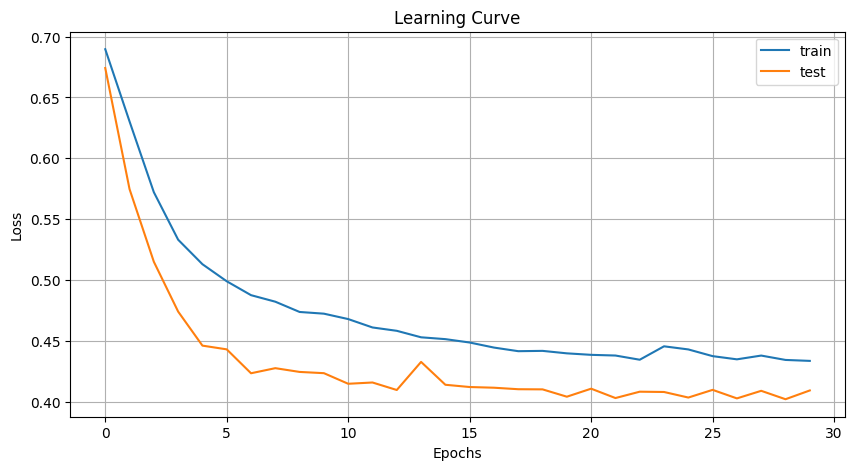

In [14]:
fig = plt.figure(figsize=(10,5))
_   = plt.grid(which='major', linestyle='-')
_   = plt.title('Learning Curve')
_   = plt.plot(train_loss_dict[dict_to_tuple(study.best_trial.params)], label='train')
_   = plt.plot(test_loss_dict[dict_to_tuple(study.best_trial.params)],  label='test')
_   = plt.ylabel('Loss')
_   = plt.xlabel('Epochs')
_   = plt.legend()
_   = plt.show()

## Accuracy, Precision, Recall, F1-Measure

In [15]:
def test_model_output(model,x_test):
    model.eval()

    x_test = x_test.view(x_test.size(0), -1)
    x_test = x_test[:,None,:]
    y_pred = torch.round(model(x_test))
    y_pred[y_pred < 0] = +0.0
    y_pred[y_pred > 1] = 1 #Turn to bool.

    return y_pred.flatten().detach().numpy()

y_pred = test_model_output(net_dict[dict_to_tuple(study.best_trial.params)],x_test)

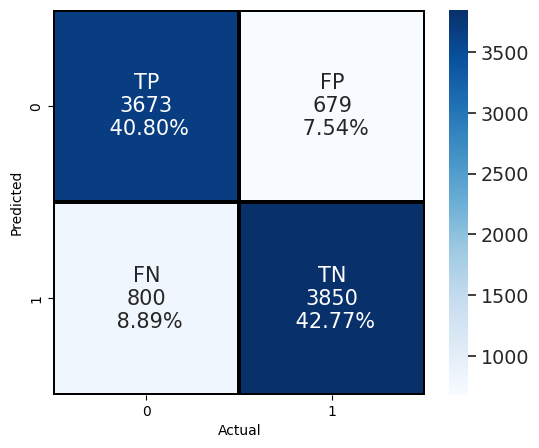

In [16]:
def confusion_matrix(y_test,y_pred):
    cm_values = metrics.confusion_matrix(y_test,y_pred)
    np.fill_diagonal(cm_values,cp.deepcopy(np.flip(cm_values.diagonal())))
                        #The output is [[tn, fp], [fn, tp]],
                        #but we need [[tp, fp], [fn, tn]],
                        #so the diagonal is reversed.

    names   = ['TP','FP','FN','TN']
    counts  = ['{0:0.0f}'.format(value) for value in cm_values.flatten()]
    percent = [' {0:.2%}'.format(value) for value in cm_values.flatten()/np.sum(cm_values)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(names,counts,percent)]
    labels = np.asarray(labels).reshape(2,2)

    fig, ax = plt.subplots(figsize=(6,5))
    sns.set(font_scale=1.25)

    r = sns.heatmap(cm_values,fmt='', linecolor='black',annot=labels,cmap='Blues',linewidths=1.5)

    _ = r.set(xlabel='Actual',ylabel='Predicted')

    return counts

counts = confusion_matrix(y_test,y_pred)

In [17]:
def confusion_metrics(counts):
    tp = int(counts[0])
    fp = int(counts[1])
    fn = int(counts[2])
    tn = int(counts[3])

    print("Recall    = ", tp / (tp + fn))
    print("Precision = ", tp / (tp + fp))
    print("Accuracy  = ",(tp + tn) / (tp + tn + fp + fn))
    print("F1-score  = ",(2 * tp)  / ( 2 * tp + fp + fn))

confusion_metrics(counts)

Recall    =  0.8211491169237648
Precision =  0.8439797794117647
Accuracy  =  0.8357031770717618
F1-score  =  0.8324079320113315


## ROC-Curve

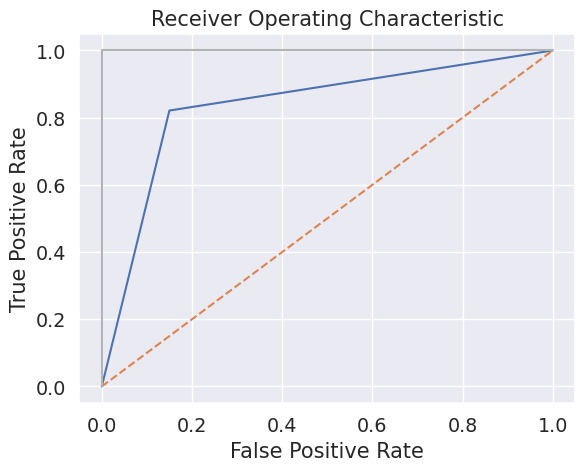

In [18]:
def Roc_Curve(y_test,y_pred):
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7")
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Roc_Curve(y_test,y_pred)